In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.gridspec import GridSpec
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
import h5py
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
print("tf.__version__",tf.__version__)

tf.__version__ 2.11.0


In [64]:
# data
corrfile = r'all_IllustrisLH_corfuncs.h5'
f = h5py.File(corrfile, 'r')
#looking to see data in cataloge
# def print_dataset_name(name,g):
#     print(name,'&',g)
# f.visititems(print_dataset_name)
corrfuncs = []
missing=[]
for filenum in range(1000):
    try:
        simcorfunc = f[f'simulation{filenum}/corrfunc'][:]
        corrfuncs.append(simcorfunc)
    except:
        print("no LH",filenum)
        missing.append(filenum)
r = f['simulation0/bins'][:]
# close file
f.close()
# labels
# Read the file
file_path = 'params_LH_IllustrisTNG.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

data_list = []
for line in lines:
    values = line.strip().split()  # Split by whitespace and remove leading/trailing spaces
    float_values = [float(val) for val in values]  # Convert strings to floats
    data_list.append(float_values)

# Convert the list to a numpy array
label_table = np.array(data_list)
label_table[:,2:] = np.log(label_table[:,2:]) # linearising distributions
# print(label_table[:10])

no LH 45
no LH 145
no LH 169
no LH 183
no LH 447
no LH 503
no LH 539
no LH 719
no LH 747
no LH 801
no LH 888
no LH 964


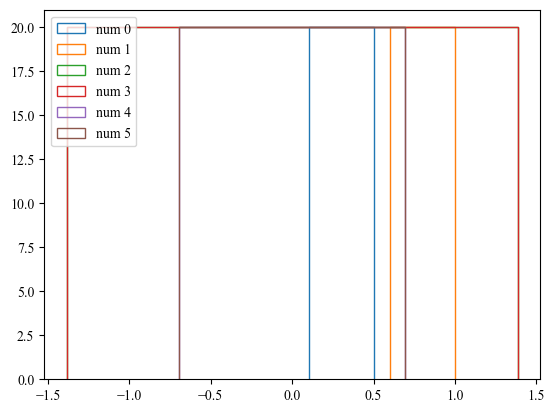

In [4]:
for i in range(6):
    plt.hist((label_table[:,i]), bins=50, histtype='step',label=f'num {i}')
plt.legend()

In [5]:
corrfuncs1 = np.array(corrfuncs)
print("data shape",corrfuncs1.shape)
# Remove the missing rows
rmvd_label_table = np.delete(label_table, missing, axis=0)
# Duplicate each row to create a new array size (988,45,6)
raw_labels = np.repeat(rmvd_label_table[:, np.newaxis, :], 45, axis=1)
print("raw labels shape", raw_labels.shape)
print()
# Splitting the data by reserving the last 100 sims for testing
corrfuncs1_testing = corrfuncs1[-100:]
corrfuncs1_training = corrfuncs1[:-100]
raw_labels_testing = raw_labels[-100:]
raw_labels_training = raw_labels[:-100]

# print("alternative training")
# corrfuncs2=np.reshape(corrfuncs1, (corrfuncs1.shape[0]*corrfuncs1.shape[1],corrfuncs1.shape[2]))
# labels2 = np.reshape(raw_labels, (raw_labels.shape[0]*raw_labels.shape[1],raw_labels.shape[2]))
# print(corrfuncs2.shape)
# print(labels2.shape)

data shape (988, 45, 8)
raw labels shape (988, 45, 6)



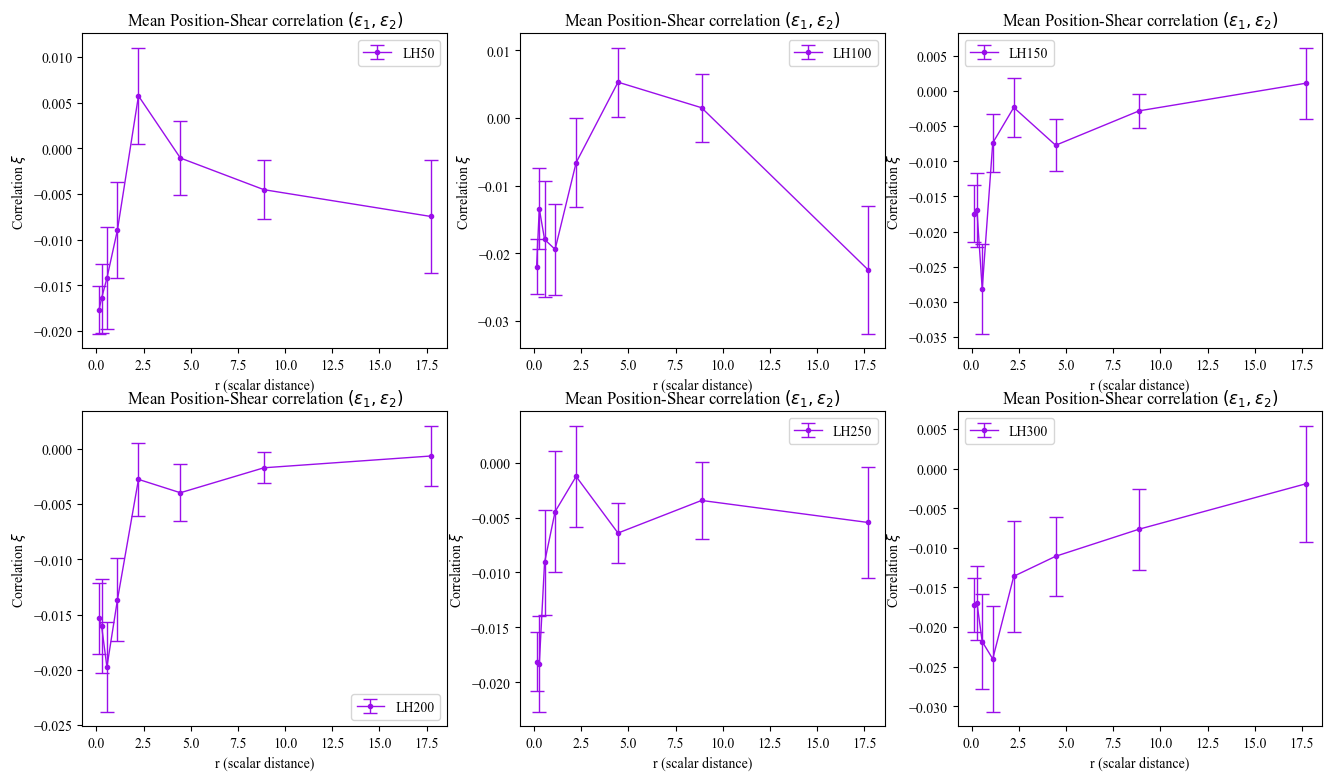

In [8]:
fig, ax = plt.subplots(2, 3,figsize=(16, 9))
k=0
for i in range(2):
    for j in range(3):
        sim_mean = np.mean(corrfuncs1[k],axis=0)
        sim_stderr = np.std(corrfuncs1[k],axis=0)/np.sqrt(45)
        k+=50
        ax[i,j].errorbar(r,sim_mean,sim_stderr,color='xkcd:violet',lw=1,
             label=f'LH{k}',capsize=5, elinewidth = 1, fmt = '.-')
        #ax[i,j].set_ylim([-0.035,0.01])
        ax[i,j].set_xlabel(r'r (scalar distance)')
        ax[i,j].set_ylabel(r'Correlation $\xi$')
        ax[i,j].set_title('Mean Position-Shear correlation $(\epsilon_1,\epsilon_2)$')
        ax[i,j].legend()

#### Bootstrap sampling - <font color='red'>training</font> 

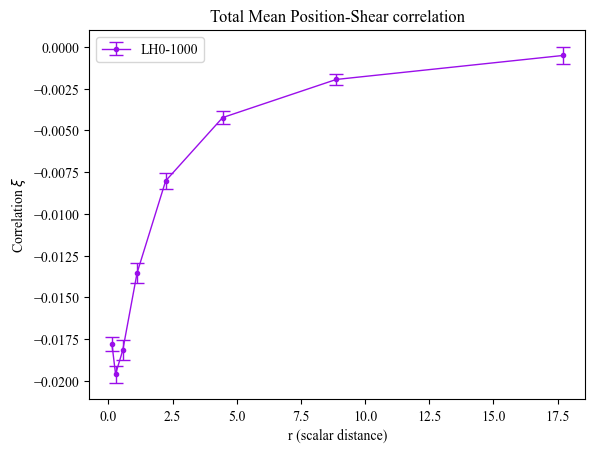

(100, 888, 8)


In [9]:
num_batches, batch_size, bins = corrfuncs1_training.shape
num_resamples = 100  # Number of bootstrap resamples

# Create an array to store the resampled means
resampled_means_training = np.empty((num_resamples, num_batches,bins))

# Perform bootstrap sampling and calculate means
for resample_idx in range(num_resamples):
    # Randomly sample indices with replacement for each batch
    sampled_indices = np.random.choice(batch_size, size=(num_batches, 30), replace=True)
    
    # Calculate means for each batch
    batch_means = np.mean(corrfuncs1[np.arange(num_batches)[:, np.newaxis], sampled_indices], axis=1)
    
    # Store the means in the resampled_means array
    resampled_means_training[resample_idx] = batch_means

# Calculate the mean and standard error of the resampled means
mean_of_means = np.mean(resampled_means_training, axis=0)
std_error_of_means = np.std(resampled_means_training, axis=0, ddof=1)  # Using Bessel's correction for sample standard deviation

# Plot tot_mean and tot_sterr for to use for normalisation later 
tot_mean = np.mean(mean_of_means,axis=0)
tot_sterr = np.mean(std_error_of_means,axis=0)/np.sqrt(num_resamples)
plt.errorbar(r,tot_mean,tot_sterr,color='xkcd:violet',lw=1,
             label=f'LH0-1000',capsize=5, elinewidth = 1, fmt = '.-')
plt.xlabel(r'r (scalar distance)')
plt.ylabel(r'Correlation $\xi$')
plt.title('Total Mean Position-Shear correlation')
plt.legend()
plt.show()
print(resampled_means_training.shape)


#### Bootstrap sampling - <font color='red'>testing</font> 

In [10]:
num_batches, batch_size, bins = corrfuncs1_testing.shape
num_resamples = 100  # Number of bootstrap resamples

# Create an array to store the resampled means
resampled_means_testing = np.empty((num_resamples, num_batches,bins))

# Perform bootstrap sampling and calculate means
for resample_idx in range(num_resamples):
    # Randomly sample indices with replacement for each batch
    sampled_indices = np.random.choice(batch_size, size=(num_batches, 30), replace=True)
    
    # Calculate means for each batch
    batch_means = np.mean(corrfuncs1[np.arange(num_batches)[:, np.newaxis], sampled_indices], axis=1)
    
    # Store the means in the resampled_means array
    resampled_means_testing[resample_idx] = batch_means

print(resampled_means_testing.shape)

(100, 100, 8)


#### Splitting data

In [30]:
bootstr_data_training = resampled_means_training.reshape((resampled_means_training.shape[0]*resampled_means_training.shape[1],8))
print("bootstrapped training data shape",bootstr_data_training.shape)
bootstr_data_testing = resampled_means_testing.reshape((resampled_means_testing.shape[0]*resampled_means_testing.shape[1],8))
print("bootstrapped testing data shape",bootstr_data_testing.shape)

# Duplicate each row to create a new array size (Ndatapoints,6 or 8)
labels_training = np.repeat(rmvd_label_table[np.newaxis,:-100, :], num_resamples, axis=0)
bootstr_labels_training = labels_training.reshape((labels_training.shape[0]*labels_training.shape[1],6))
labels_testing = np.repeat(rmvd_label_table[np.newaxis,-100:, :], num_resamples, axis=0)
bootstr_labels_testing = labels_testing.reshape((labels_testing.shape[0]*labels_testing.shape[1],6))
print("bootstrapped labels training shape", bootstr_labels_training.shape)
print("bootstrapped labels testing shape", bootstr_labels_testing.shape)
# normalising labels for training
mean_labels = np.mean(bootstr_labels_training,axis=0)
std_labels = np.std(bootstr_labels_training,axis=0)
print(mean_labels)
print(std_labels)
bootstr_labels_n_training = (bootstr_labels_training-mean_labels) / (5*std_labels)  + 0.5 # mean of 0.5, std of 0.2
bootstr_labels_n_testing = (bootstr_labels_testing-mean_labels) / (5*std_labels)  + 0.5 # mean of 0.5, std of 0.2
#print(bootstr_labels_n[:10])
# normalising data
mean_data = np.mean(bootstr_data_training,axis=0)
std_data = np.std(bootstr_data_training,axis=0)
print(mean_data)
print(std_data)
bootstr_data_n_training = (bootstr_data_training-mean_data)/(std_data*5)  # mean of 0, std of 0.2
bootstr_data_n_testing = (bootstr_data_testing-mean_data)/(std_data*5)    # mean of 0, std of 0.2
test_data = bootstr_data_n_testing
test_label = bootstr_labels_n_testing

bootstrapped training data shape (88800, 8)
bootstrapped testing data shape (10000, 8)
bootstrapped labels training shape (88800, 6)
bootstrapped labels testing shape (10000, 6)
[ 3.00345946e-01  8.00680631e-01 -1.56770824e-02  5.63560999e-03
 -3.26269912e-04  2.35428071e-03]
[0.11468567 0.11573261 0.8003495  0.79446464 0.40037197 0.40001724]
[-0.017788   -0.01958825 -0.01816416 -0.01353136 -0.00802019 -0.00423144
 -0.00194927 -0.000514  ]
[0.0072017  0.00859972 0.00974172 0.00988858 0.00792377 0.00583048
 0.00457517 0.00774605]


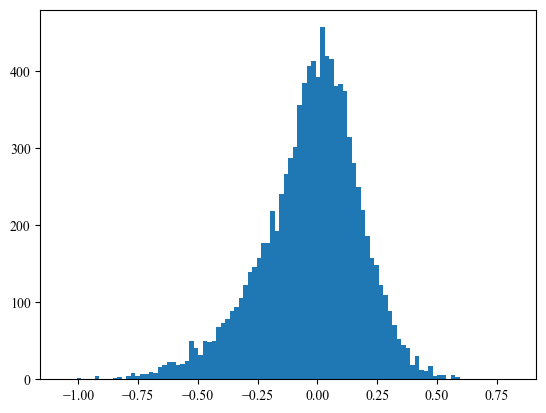

In [31]:
_= plt.hist(bootstr_data_n_testing[:,3], bins=100)

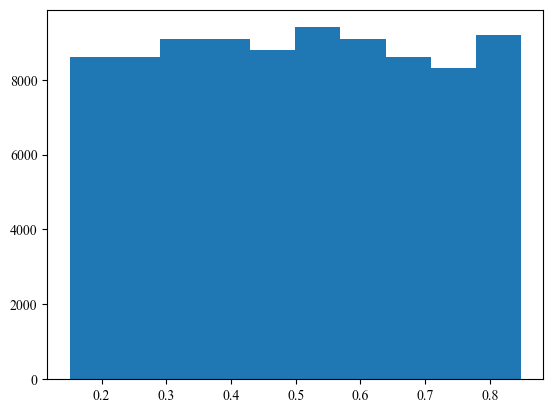

In [37]:
plt.hist(bootstr_labels_n_training[:,0])
plt.show()

In [15]:
train_data, val_data, train_label, val_label = train_test_split(bootstr_data_n_training, bootstr_labels_n_training, test_size = 0.1, random_state = 6)
print(train_data.shape, train_label.shape)
print(val_data.shape, val_label.shape)

(79920, 8) (79920, 6)
(8880, 8) (8880, 6)


#### Build Model

In [16]:
# normalizer = tf.keras.layers.Normalization(axis=-1, input_shape=(8,))
# normalizer.adapt(train_data)
# mean_value = normalizer.mean.numpy()
# variance_value = normalizer.variance.numpy()
# print("Input Normalization Mean:", mean_value)
# print("Input Normalization Variance:", variance_value)

In [59]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(50, input_shape=(8,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(50, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(32, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                450       
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 32)                1632      
                                                                 
 dense_13 (Dense)            (None, 8)                 264       
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,905
Trainable params: 4,905
Non-trainable params: 0
_________________________________________________________________


In [60]:
param=4
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,param],epochs=10,batch_size=32,verbose=1,validation_data=(val_data,val_label[:,param]))
print()

313/313 [==============================] - 1s 2ms/step
Epoch 1/10
2498/2498 [==============================] - 8s 3ms/step - loss: 0.0313 - val_loss: 0.0309
Epoch 2/10
2498/2498 [==============================] - 6s 3ms/step - loss: 0.0306 - val_loss: 0.0307
Epoch 3/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.0304 - val_loss: 0.0305
Epoch 4/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.0302 - val_loss: 0.0305
Epoch 5/10
2498/2498 [==============================] - 6s 2ms/step - loss: 0.0301 - val_loss: 0.0304
Epoch 6/10
2498/2498 [==============================] - 6s 2ms/step - loss: 0.0300 - val_loss: 0.0303
Epoch 7/10
2498/2498 [==============================] - 6s 2ms/step - loss: 0.0299 - val_loss: 0.0302
Epoch 8/10
2498/2498 [==============================] - 8s 3ms/step - loss: 0.0298 - val_loss: 0.0302
Epoch 9/10
2498/2498 [==============================] - 7s 3ms/step - loss: 0.0297 - val_loss: 0.0301
Epoch 10/10
2498/2498 [====

End validation loss is: 0.030301453545689583


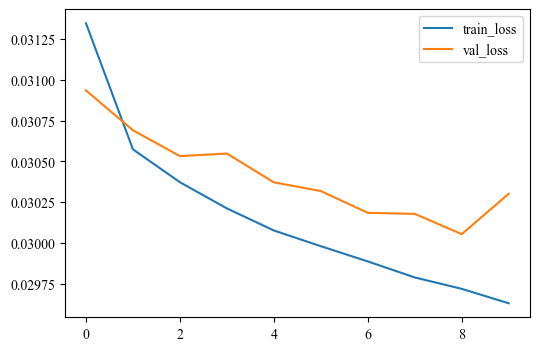

In [61]:
print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

### Testing the testing data

313/313 [==============================] - 1s 2ms/step


Text(0.5, 0, 'simulation value $\\Omega_m$')

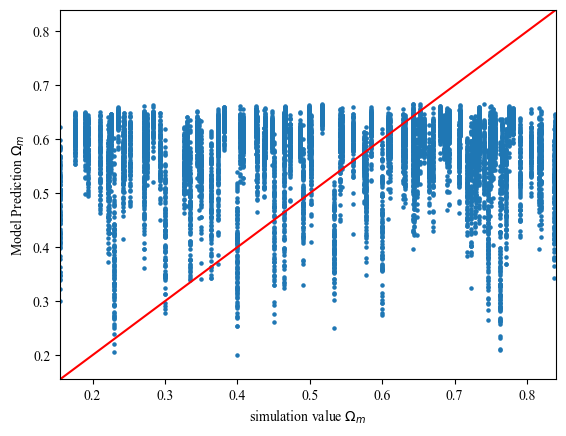

In [57]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{SN2}','A_{AGN1}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]
test_predict=model.predict(test_data, verbose=1)
plt.plot([0,1],[0,1],c='r')
plt.scatter(test_label[:,param], test_predict,s=5)
plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')

### Testing the validation data

278/278 [==============================] - 1s 2ms/step


Text(0.5, 0, 'simulation value $\\Omega_m$')

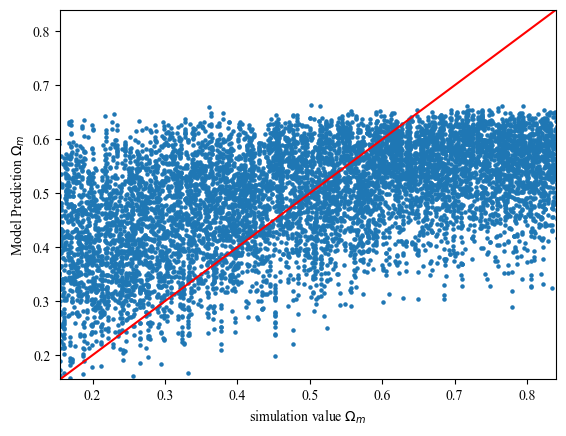

In [58]:
val_predict=model.predict(val_data, verbose=1)
plt.plot([0,1],[0,1],c='r')
plt.scatter(val_label[:,param], val_predict,s=5)
plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')

In [40]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{SN2}','A_{AGN1}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]

test_predict=model.predict(test_data, verbose=1)

pre_predict = (pre_test_predict - 0.5)*5*std_labels[param] + mean_labels[param]
predict = (test_predict - 0.5)*5*std_labels[param] + mean_labels[param]
actual = (test_label[:,param] - 0.5)*5*std_labels[param] + mean_labels[param]

313/313 [==============================] - 0s 2ms/step


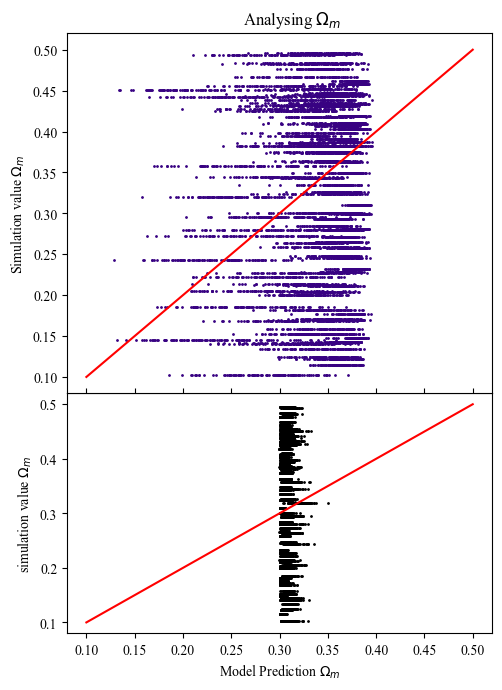

In [41]:
fig = plt.figure(figsize=(5, 8))
fig.suptitle(f"Analysing ${simpars[param]}$")
gs = GridSpec(5, 10, figure=fig)

ax2 = fig.add_subplot(gs[3:5, :10])
ax1 = fig.add_subplot(gs[:3, :10])

#ax1.hist2d(predict[:,0], actual, cmap='Purples', norm=colors.LogNorm(), bins=64)
ax1.scatter(predict, actual, marker='o', s=1, alpha=1.0, c='xkcd:indigo')
ax1.plot(lims[param],lims[param],c='r')
#ax1.set_xlabel(f'Model Prediction ${simpars[param]}$')
ax1.set_ylabel(f'Simulation value ${simpars[param]}$')
# ax1.set_xlim(lims[param])#+np.array([-0.1,0.1]))
# ax1.set_ylim(lims[param]+np.array([-0.02,0.02]))
ax1.tick_params(axis="x",direction="in",labelbottom=False)

ax2.scatter(pre_predict, actual, marker='o', s=1, alpha=1.0, c='k')
#ax2.hist2d(pre_predict[:,0], actual, cmap='Greys', norm=colors.LogNorm(), bins=64)
ax2.plot(lims[param],lims[param],c='r')
ax2.set_xlabel(f'Model Prediction ${simpars[param]}$')
ax2.set_ylabel(f'simulation value ${simpars[param]}$')
# ax2.set_xlim(lims[param])#+np.array([-0.1,0.1]))
# ax2.set_ylim(lims[param]+np.array([-0.02,0.02]))


plt.subplots_adjust(left=0.05,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.95, 
                    hspace=0.0)  #Ad

(0.08, 0.52)

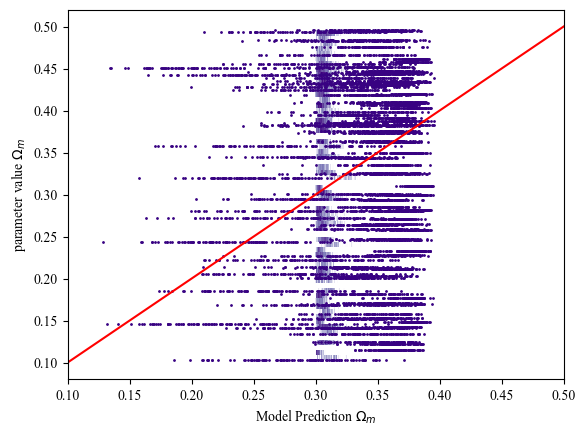

In [52]:
plt.hist2d(pre_predict[:,0], actual, cmap='Purples', norm=colors.LogNorm(), bins=64)
plt.scatter(predict, actual, marker='o', s=1, alpha=1.0, c='xkcd:indigo')
plt.plot(lims[param],lims[param],c='r')
plt.xlabel(f'Model Prediction ${simpars[param]}$')
plt.ylabel(f'parameter value ${simpars[param]}$')
plt.xlim(lims[param])#+np.array([-0.1,0.1]))
plt.ylim(lims[param]+np.array([-0.02,0.02]))

In [29]:
model.evaluate(train_data, train_label[:,param], verbose=0)

0.061427656561136246